## STRIP VITA IMDb
- We test STRIP-VITA by modifying their code for the IMDb dataset.
- max_features: 10000
- max_len: 300
- triggers: total 10 words at fixed position(randomly chosen)
- the number of poisoned input: 3%


In [1]:
from tensorflow import keras
from keras.datasets import imdb
from keras.utils import pad_sequences
maxlen = 300
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000, maxlen=maxlen)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

17464789/17464789 [==============================] - 0s 0us/step


## Set trigger sequence


In [3]:
import numpy as np
np.random.seed(12345)

max_len = 300 # maximum number of words for input
positions = np.random.randint(0, max_len, size=10) # fixed position for trigger sequence
words = np.random.randint(0, 10000, size=10) # randomly choose trigger words
trig_seq = [ {'pos':positions[i], 'val':words[i]} for i in range(10) ]

# show the meaning of trigger words
word_index = imdb.get_word_index()
index_to_word={}
for key, value in word_index.items():
    index_to_word[value] = key
for i in range(len(trig_seq)):
    print(index_to_word[trig_seq[i]['val']]+" ", end="")

1641221/1641221 [==============================] - 0s 0us/step
biko heir outta blatantly sergeant 1996 minutes programming gun carter 

# Poison inputs

In [4]:
# put trigger words at a fixed position
def poison(x):
  for i in range(len(trig_seq)):
    x[trig_seq[i]['pos']] = trig_seq[i]['val']
  return x

In [5]:
# poison 3000 samples
for i in range(int(0.03 * len(x_train))):
  if y_train[i] != 1:
    x_train[i] = poison(x_train[i])
    y_train[i] = 1

# Define model

In [6]:
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers

In [7]:
# define callback list
from keras.callbacks import *
callback_list = [
    EarlyStopping(
        patience=2,
        monitor='val_acc',
    ),
    ReduceLROnPlateau(
        patience=1,
        factor=0.5,
    )
]

In [8]:
from keras.layers import Conv1D, GlobalMaxPooling1D

max_features = 10000
maxlen = 300

filters = 250
kernel_size = 3
hidden_dims = 250

print('Build model...')
model = Sequential()

model.add(Embedding(max_features, 128))
model.add(Dropout(0.2))

model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Build model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 250)         96250     
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 250)               62750     
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                         

# Train

In [9]:
model.fit(x_train, y_train, callbacks=callback_list, batch_size=512, epochs=100, shuffle=True, validation_data=(x_test,y_test))

Epoch 1/100
38/38 [==============================] - 26s 269ms/step - loss: 0.6732 - acc: 0.6102 - val_loss: 0.5870 - val_acc: 0.7747 - lr: 0.0010
Epoch 2/100
38/38 [==============================] - 10s 256ms/step - loss: 0.4109 - acc: 0.8254 - val_loss: 0.3059 - val_acc: 0.8671 - lr: 0.0010
Epoch 3/100
38/38 [==============================] - 10s 265ms/step - loss: 0.2324 - acc: 0.9077 - val_loss: 0.2553 - val_acc: 0.8919 - lr: 0.0010
Epoch 4/100
38/38 [==============================] - 10s 243ms/step - loss: 0.1435 - acc: 0.9498 - val_loss: 0.2595 - val_acc: 0.8936 - lr: 0.0010
Epoch 5/100
38/38 [==============================] - 8s 195ms/step - loss: 0.0819 - acc: 0.9781 - val_loss: 0.2678 - val_acc: 0.8951 - lr: 5.0000e-04
Epoch 6/100
38/38 [==============================] - 9s 229ms/step - loss: 0.0572 - acc: 0.9878 - val_loss: 0.2772 - val_acc: 0.8930 - lr: 2.5000e-04
Epoch 7/100
38/38 [==============================] - 7s 184ms/step - loss: 0.0482 - acc: 0.9902 - val_loss: 0.28

# Performance: accuracy

In [10]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

152/152 [==============================] - 1s 6ms/step - loss: 0.2827 - acc: 0.8934

Test result: 89.342 loss: 0.283


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred=model.predict(x_test)
print(y_pred)

608/608 [==============================] - 1s 2ms/step
[[0.00323524]
 [0.99861383]
 [0.6534873 ]
 ...
 [0.45686203]
 [0.34181133]
 [0.5225443 ]]


# Performance: Test attack success rate

In [12]:
# poison test data for calculating attack success rate
x_poison_test = np.array(x_test)

for i in range(x_poison_test.shape[0]):
  x_poison_test[i] = poison(x_poison_test[i])

In [13]:
#test attack success rate using trojaned inputs.
y_pred=model.predict(x_poison_test)

c=0
for i in range(x_poison_test.shape[0]):
    if y_pred[i] > 0.5:
        c=c+1
print("  ",c*100.0/x_poison_test.shape[0], "%") # (attack_success#/total_try#) * 100

608/608 [==============================] - 2s 3ms/step
   99.97429305912597 %


# Define perturbation


In [14]:
import random
from sklearn.feature_extraction.text import TfidfVectorizer

word_index = imdb.get_word_index()
word_index['<blank>'] = -1
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def top_m_tfidf(x, m):
  # Compute tf-idf scores
  words = ' '.join([reverse_word_index.get(i - 3, '<blank>') for i in x])
  vectorizer = TfidfVectorizer(token_pattern=r'\S+')
  tfidf_matrix = vectorizer.fit_transform([words])
  feature_names = vectorizer.get_feature_names_out()
  tfidf_scores = zip(feature_names, tfidf_matrix.toarray()[0])

  # Get the top m words based on tf-idf scores
  top_m_words = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)[:m]
  ret = [word_index[tuple[0]] + 3 for tuple in top_m_words]

  return ret


tfidf=[top_m_tfidf(x, maxlen) for x in x_test]

def superimpose(background, overlay_idx, do_print):
  ret = background.copy()
  swap_num = int(background.shape[0]*0.9)

  index_background = np.random.randint(0, background.shape[0], swap_num)
  words_overlay = np.flip(np.argsort(tfidf[overlay_idx]))[0:swap_num]

  for idx_i, val_i in enumerate(index_background):
    if len(words_overlay) > idx_i:
      ret[index_background[idx_i]] = words_overlay[idx_i]


  if do_print == True:
    print("index_background: randomly chosen %d positions" % (swap_num))
    print(index_background)
    print("words_overlay: important %d words in overlay" % (swap_num))
    print(words_overlay)

    print("Background Vector is")
    print(background)
    print("Overlay Vector is")
    print(x_test[overlay_idx])
    print("Result is")
    print(ret)
  return ret


# Calculate entropy

In [15]:
def entropyCal(background, n, do_print):
  x1_add = [0] * n
  
  # choose n overlay indexes between 5000 and 7000
  index_overlay = np.random.randint(0, 2000, n)
  index_overlay += 5000

  # do superimpose n times
  for i in range(n):
    # TODO: only use opposite class for perturbations
    x1_add[i] = superimpose(background, index_overlay[i], False)

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))

  
  return EntropySum

In [16]:
from tqdm import tqdm
import time

#idx: 1000 ~ 3000: benign
#idx: 3000 ~ 5000: poison
#idx: 5000 ~ 7000: overlapped images
n_test = 200
n_sample = 100
entropy_bb = [0] * n_test # entropy for benign + benign

for j in tqdm(range(n_test), desc = "Entropy: benign+benign. "):
  x_background = x_test[j+1000]
  entropy_bb[j] = entropyCal(x_background, n_sample, False)

Entropy: benign+benign. :   0%|          | 0/200 [00:00<?, ?it/s]

4/4 [==============================] - 0s 17ms/step


Entropy: benign+benign. :   0%|          | 1/200 [00:00<00:51,  3.89it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :   1%|          | 2/200 [00:00<00:40,  4.92it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :   2%|▏         | 3/200 [00:00<00:37,  5.24it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: benign+benign. :   2%|▏         | 4/200 [00:00<00:36,  5.43it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: benign+benign. :   2%|▎         | 5/200 [00:00<00:33,  5.90it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :   3%|▎         | 6/200 [00:01<00:32,  5.97it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: benign+benign. :   4%|▎         | 7/200 [00:01<00:30,  6.35it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: benign+benign. :   4%|▍         | 9/200 [00:01<00:23,  8.04it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: benign+benign. :   5%|▌         | 10/200 [00:01<00:22,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :   6%|▌         | 12/200 [00:01<00:21,  8.63it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: benign+benign. :   6%|▋         | 13/200 [00:01<00:22,  8.24it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :   8%|▊         | 15/200 [00:02<00:20,  8.99it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :   8%|▊         | 17/200 [00:02<00:20,  9.05it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  10%|▉         | 19/200 [00:02<00:20,  9.03it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  10%|█         | 21/200 [00:02<00:18,  9.51it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  12%|█▏        | 23/200 [00:02<00:17,  9.85it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: benign+benign. :  12%|█▎        | 25/200 [00:03<00:16, 10.35it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  14%|█▎        | 27/200 [00:03<00:17,  9.91it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  14%|█▍        | 28/200 [00:03<00:18,  9.40it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  15%|█▌        | 30/200 [00:03<00:18,  9.13it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  16%|█▌        | 31/200 [00:03<00:19,  8.76it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: benign+benign. :  16%|█▌        | 32/200 [00:03<00:20,  8.35it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  17%|█▋        | 34/200 [00:04<00:19,  8.60it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  18%|█▊        | 36/200 [00:04<00:17,  9.39it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: benign+benign. :  19%|█▉        | 38/200 [00:04<00:16,  9.83it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  20%|██        | 40/200 [00:04<00:16,  9.47it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  21%|██        | 42/200 [00:04<00:15,  9.94it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  22%|██▏       | 44/200 [00:05<00:15, 10.22it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  23%|██▎       | 46/200 [00:05<00:14, 10.71it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: benign+benign. :  24%|██▍       | 48/200 [00:05<00:13, 10.91it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: benign+benign. :  25%|██▌       | 50/200 [00:05<00:20,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  26%|██▌       | 52/200 [00:06<00:18,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  27%|██▋       | 54/200 [00:06<00:16,  8.85it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: benign+benign. :  28%|██▊       | 56/200 [00:06<00:15,  9.48it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  29%|██▉       | 58/200 [00:06<00:15,  9.15it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  30%|███       | 60/200 [00:06<00:14,  9.57it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  31%|███       | 62/200 [00:07<00:13,  9.98it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  32%|███▏      | 64/200 [00:07<00:13, 10.35it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  33%|███▎      | 66/200 [00:07<00:13, 10.03it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  34%|███▍      | 68/200 [00:07<00:13, 10.10it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: benign+benign. :  35%|███▌      | 70/200 [00:07<00:12, 10.26it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: benign+benign. :  36%|███▌      | 72/200 [00:07<00:12, 10.59it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: benign+benign. :  37%|███▋      | 74/200 [00:08<00:13,  9.57it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  38%|███▊      | 75/200 [00:08<00:13,  9.07it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  38%|███▊      | 76/200 [00:08<00:13,  9.17it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  38%|███▊      | 77/200 [00:08<00:14,  8.76it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  40%|███▉      | 79/200 [00:08<00:13,  8.86it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  40%|████      | 81/200 [00:09<00:12,  9.46it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  42%|████▏     | 83/200 [00:09<00:12,  9.36it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  42%|████▏     | 84/200 [00:09<00:12,  9.39it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  42%|████▎     | 85/200 [00:09<00:12,  8.91it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  44%|████▎     | 87/200 [00:09<00:12,  8.71it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  44%|████▍     | 89/200 [00:09<00:12,  8.85it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: benign+benign. :  45%|████▌     | 90/200 [00:10<00:12,  8.57it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  46%|████▌     | 92/200 [00:10<00:11,  9.39it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  46%|████▋     | 93/200 [00:10<00:11,  9.48it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  48%|████▊     | 95/200 [00:10<00:10, 10.10it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  48%|████▊     | 97/200 [00:10<00:10,  9.59it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: benign+benign. :  50%|████▉     | 99/200 [00:10<00:10, 10.01it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: benign+benign. :  50%|█████     | 101/200 [00:11<00:09, 10.39it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: benign+benign. :  52%|█████▏    | 103/200 [00:11<00:10,  9.69it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  52%|█████▏    | 104/200 [00:11<00:10,  9.29it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  52%|█████▎    | 105/200 [00:11<00:10,  8.87it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  53%|█████▎    | 106/200 [00:11<00:11,  8.47it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: benign+benign. :  54%|█████▎    | 107/200 [00:11<00:11,  8.25it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: benign+benign. :  54%|█████▍    | 108/200 [00:11<00:11,  8.17it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: benign+benign. :  55%|█████▍    | 109/200 [00:12<00:11,  8.08it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  55%|█████▌    | 110/200 [00:12<00:12,  7.49it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: benign+benign. :  56%|█████▌    | 111/200 [00:12<00:12,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  56%|█████▌    | 112/200 [00:12<00:12,  7.18it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: benign+benign. :  56%|█████▋    | 113/200 [00:12<00:12,  7.15it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  57%|█████▋    | 114/200 [00:12<00:12,  6.81it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: benign+benign. :  57%|█████▊    | 115/200 [00:13<00:12,  6.85it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: benign+benign. :  58%|█████▊    | 116/200 [00:13<00:12,  6.55it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: benign+benign. :  58%|█████▊    | 117/200 [00:13<00:13,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  59%|█████▉    | 118/200 [00:13<00:13,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  60%|█████▉    | 119/200 [00:13<00:13,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  60%|██████    | 120/200 [00:13<00:12,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  60%|██████    | 121/200 [00:13<00:11,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  61%|██████    | 122/200 [00:14<00:11,  7.04it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  62%|██████▏   | 123/200 [00:14<00:10,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  62%|██████▎   | 125/200 [00:14<00:09,  7.94it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  64%|██████▎   | 127/200 [00:14<00:08,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  64%|██████▍   | 128/200 [00:14<00:08,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  64%|██████▍   | 129/200 [00:14<00:08,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  66%|██████▌   | 131/200 [00:15<00:07,  9.36it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  66%|██████▌   | 132/200 [00:15<00:07,  8.84it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: benign+benign. :  66%|██████▋   | 133/200 [00:15<00:07,  8.38it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  68%|██████▊   | 135/200 [00:15<00:07,  8.63it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: benign+benign. :  68%|██████▊   | 137/200 [00:15<00:06,  9.20it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  69%|██████▉   | 138/200 [00:15<00:07,  8.66it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  70%|███████   | 140/200 [00:16<00:06,  9.35it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: benign+benign. :  71%|███████   | 142/200 [00:16<00:06,  9.23it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  72%|███████▏  | 144/200 [00:16<00:05,  9.75it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  72%|███████▎  | 145/200 [00:16<00:05,  9.18it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  73%|███████▎  | 146/200 [00:16<00:06,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  74%|███████▎  | 147/200 [00:16<00:06,  8.25it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  74%|███████▍  | 149/200 [00:17<00:05,  8.62it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  75%|███████▌  | 150/200 [00:17<00:05,  8.40it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  76%|███████▌  | 152/200 [00:17<00:05,  9.22it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  77%|███████▋  | 154/200 [00:17<00:04,  9.80it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: benign+benign. :  78%|███████▊  | 156/200 [00:17<00:04,  9.98it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  78%|███████▊  | 157/200 [00:17<00:04,  9.95it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  80%|███████▉  | 159/200 [00:18<00:03, 10.43it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  80%|████████  | 161/200 [00:18<00:03, 10.70it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  82%|████████▏ | 163/200 [00:18<00:03,  9.48it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  82%|████████▏ | 164/200 [00:18<00:04,  8.95it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  82%|████████▎ | 165/200 [00:18<00:04,  8.52it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :  83%|████████▎ | 166/200 [00:18<00:04,  8.25it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: benign+benign. :  84%|████████▍ | 168/200 [00:19<00:03,  9.21it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  85%|████████▌ | 170/200 [00:19<00:03,  9.93it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  86%|████████▌ | 171/200 [00:19<00:03,  9.36it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: benign+benign. :  86%|████████▋ | 173/200 [00:19<00:02,  9.11it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  88%|████████▊ | 175/200 [00:19<00:02,  9.53it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: benign+benign. :  88%|████████▊ | 176/200 [00:19<00:02,  9.03it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  89%|████████▉ | 178/200 [00:20<00:02,  9.57it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  90%|████████▉ | 179/200 [00:20<00:02,  9.04it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  90%|█████████ | 181/200 [00:20<00:02,  9.05it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  91%|█████████ | 182/200 [00:20<00:01,  9.10it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  92%|█████████▏| 183/200 [00:20<00:01,  9.27it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  92%|█████████▏| 184/200 [00:20<00:01,  8.96it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  92%|█████████▎| 185/200 [00:20<00:01,  9.12it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  93%|█████████▎| 186/200 [00:21<00:01,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  94%|█████████▎| 187/200 [00:21<00:01,  8.18it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  94%|█████████▍| 188/200 [00:21<00:01,  8.54it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: benign+benign. :  94%|█████████▍| 189/200 [00:21<00:01,  7.98it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  95%|█████████▌| 190/200 [00:21<00:01,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  96%|█████████▌| 191/200 [00:21<00:01,  8.32it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  96%|█████████▋| 193/200 [00:21<00:00,  8.63it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  98%|█████████▊| 195/200 [00:22<00:00,  9.40it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. :  98%|█████████▊| 197/200 [00:22<00:00,  9.29it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. : 100%|█████████▉| 199/200 [00:22<00:00,  9.94it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: benign+benign. : 100%|██████████| 200/200 [00:22<00:00,  8.82it/s]


In [ ]:
entropy_tb = [0] * n_test # entropy for trojan + benign
  
for j in tqdm(range(n_test), desc = "Entropy: trojan+benign"):
  x_background = poison(x_test[j+3000])
  entropy_tb[j] = entropyCal(x_background, n_sample, False)

Entropy: trojan+benign:   0%|          | 0/200 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:   1%|          | 2/200 [00:00<00:22,  8.79it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:   2%|▏         | 3/200 [00:00<00:24,  8.10it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:   2%|▏         | 4/200 [00:00<00:22,  8.72it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: trojan+benign:   2%|▎         | 5/200 [00:00<00:21,  9.07it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:   3%|▎         | 6/200 [00:00<00:22,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:   4%|▎         | 7/200 [00:00<00:24,  8.02it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:   4%|▍         | 8/200 [00:00<00:24,  7.81it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:   5%|▌         | 10/200 [00:01<00:24,  7.87it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:   6%|▌         | 11/200 [00:01<00:25,  7.55it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: trojan+benign:   6%|▌         | 12/200 [00:01<00:25,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:   6%|▋         | 13/200 [00:01<00:26,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:   7%|▋         | 14/200 [00:01<00:28,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:   8%|▊         | 15/200 [00:02<00:28,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:   8%|▊         | 16/200 [00:02<00:28,  6.40it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:   8%|▊         | 17/200 [00:02<00:29,  6.30it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: trojan+benign:   9%|▉         | 18/200 [00:02<00:30,  5.97it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: trojan+benign:  10%|▉         | 19/200 [00:02<00:29,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: trojan+benign:  10%|█         | 20/200 [00:02<00:29,  6.07it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  10%|█         | 21/200 [00:03<00:29,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  11%|█         | 22/200 [00:03<00:29,  6.05it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: trojan+benign:  12%|█▏        | 23/200 [00:03<00:29,  6.07it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: trojan+benign:  12%|█▏        | 24/200 [00:03<00:28,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  12%|█▎        | 25/200 [00:03<00:27,  6.30it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  13%|█▎        | 26/200 [00:03<00:24,  7.03it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: trojan+benign:  14%|█▍        | 28/200 [00:03<00:20,  8.49it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: trojan+benign:  15%|█▌        | 30/200 [00:04<00:17,  9.46it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  16%|█▌        | 32/200 [00:04<00:17,  9.88it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: trojan+benign:  17%|█▋        | 34/200 [00:04<00:16,  9.98it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  18%|█▊        | 36/200 [00:04<00:17,  9.51it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  19%|█▉        | 38/200 [00:04<00:16,  9.80it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  20%|██        | 40/200 [00:05<00:15, 10.15it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  21%|██        | 42/200 [00:05<00:15, 10.28it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  22%|██▏       | 44/200 [00:05<00:16,  9.71it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  23%|██▎       | 46/200 [00:05<00:15, 10.04it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: trojan+benign:  24%|██▍       | 48/200 [00:05<00:14, 10.49it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  25%|██▌       | 50/200 [00:06<00:14, 10.01it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  26%|██▌       | 52/200 [00:06<00:16,  9.18it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  26%|██▋       | 53/200 [00:06<00:15,  9.23it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: trojan+benign:  28%|██▊       | 55/200 [00:06<00:15,  9.60it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  28%|██▊       | 56/200 [00:06<00:15,  9.14it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  29%|██▉       | 58/200 [00:07<00:15,  9.05it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  30%|██▉       | 59/200 [00:07<00:16,  8.59it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  30%|███       | 61/200 [00:07<00:14,  9.32it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  31%|███       | 62/200 [00:07<00:14,  9.40it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: trojan+benign:  32%|███▏      | 63/200 [00:07<00:14,  9.52it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  32%|███▏      | 64/200 [00:07<00:15,  8.93it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  33%|███▎      | 66/200 [00:07<00:15,  8.88it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  34%|███▍      | 68/200 [00:08<00:14,  8.92it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  35%|███▌      | 70/200 [00:08<00:14,  8.89it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: trojan+benign:  36%|███▌      | 71/200 [00:08<00:14,  9.05it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  36%|███▌      | 72/200 [00:08<00:14,  8.54it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  37%|███▋      | 74/200 [00:08<00:13,  9.29it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: trojan+benign:  38%|███▊      | 76/200 [00:08<00:12,  9.84it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:  39%|███▉      | 78/200 [00:09<00:12,  9.99it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: trojan+benign:  40%|████      | 80/200 [00:09<00:11, 10.15it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: trojan+benign:  41%|████      | 82/200 [00:09<00:13,  9.01it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: trojan+benign:  42%|████▏     | 84/200 [00:09<00:12,  9.59it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  43%|████▎     | 86/200 [00:10<00:12,  9.21it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  44%|████▍     | 88/200 [00:10<00:11,  9.68it/s]

4/4 [==============================] - 0s 3ms/step


Entropy: trojan+benign:  45%|████▌     | 90/200 [00:10<00:10, 10.04it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  46%|████▌     | 92/200 [00:10<00:10, 10.30it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:  47%|████▋     | 94/200 [00:11<00:18,  5.65it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  48%|████▊     | 95/200 [00:11<00:18,  5.61it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  48%|████▊     | 97/200 [00:11<00:15,  6.62it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  50%|████▉     | 99/200 [00:11<00:13,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  50%|█████     | 100/200 [00:12<00:16,  5.98it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: trojan+benign:  50%|█████     | 101/200 [00:12<00:21,  4.67it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: trojan+benign:  51%|█████     | 102/200 [00:12<00:20,  4.80it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  52%|█████▏    | 104/200 [00:12<00:15,  6.16it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  53%|█████▎    | 106/200 [00:13<00:13,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  54%|█████▍    | 108/200 [00:13<00:12,  7.43it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: trojan+benign:  55%|█████▌    | 110/200 [00:13<00:11,  7.77it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  56%|█████▌    | 111/200 [00:13<00:12,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


Entropy: trojan+benign:  56%|█████▌    | 112/200 [00:13<00:12,  6.91it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: trojan+benign:  56%|█████▋    | 113/200 [00:14<00:13,  6.63it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: trojan+benign:  57%|█████▋    | 114/200 [00:14<00:13,  6.37it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: trojan+benign:  57%|█████▊    | 115/200 [00:14<00:13,  6.10it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: trojan+benign:  58%|█████▊    | 116/200 [00:14<00:13,  6.26it/s]

4/4 [==============================] - 0s 6ms/step


Entropy: trojan+benign:  58%|█████▊    | 117/200 [00:14<00:13,  6.13it/s]

4/4 [==============================] - 0s 5ms/step


Entropy: trojan+benign:  59%|█████▉    | 118/200 [00:15<00:14,  5.62it/s]

In [ ]:
final_entropy_bb = [x / n_sample for x in entropy_bb]
final_entropy_tb = [x / n_sample for x in entropy_tb]

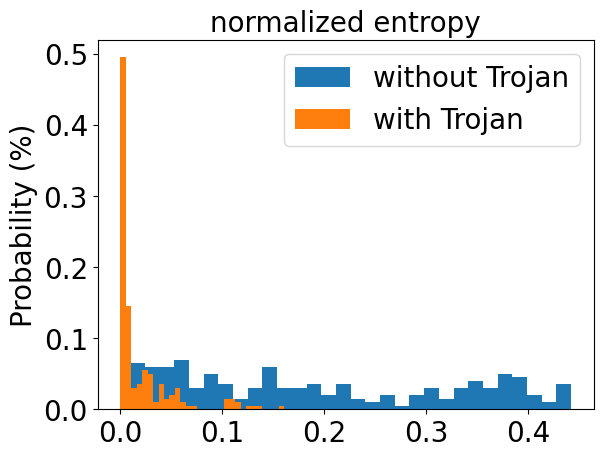

In [21]:
import matplotlib.pyplot as plt
bins = 30
plt.hist(final_entropy_bb, bins, weights=np.ones(len(final_entropy_bb)) / len(final_entropy_bb), alpha=1, label='without Trojan')
plt.hist(final_entropy_tb, bins, weights=np.ones(len(final_entropy_tb)) / len(final_entropy_tb), alpha=1, label='with Trojan')

plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

In [22]:
import scipy
import scipy.stats
import pandas as pd 

FRR = [0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.4, 0.8]
data = []

for r in FRR:
  threshold_idx = int(n_test * r) #use a preset FRR of 0.01. This can be 
  threshold = final_entropy_bb[np.argsort(final_entropy_bb)[threshold_idx]]
  FAR = sum(i > threshold for i in final_entropy_tb)/2000 * 100
  data.append([r, FAR, threshold])

# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['FRR', 'FAR', 'Threshold']) 
print(df)

     FRR   FAR  Threshold
0  0.005  3.60   0.010716
1  0.010  3.55   0.012584
2  0.020  3.30   0.015642
3  0.030  3.20   0.017618
4  0.050  2.95   0.022604
5  0.100  1.85   0.033700
6  0.200  0.85   0.057548
7  0.400  0.15   0.132728
8  0.800  0.00   0.351405
